In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import xgboost as xgb
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\Users\Davee\Miniconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Davee\AppData\Local\Temp\tmpkzhewppr
  JVM stdout: C:\Users\Davee\AppData\Local\Temp\tmpkzhewppr\h2o_Davee_started_from_python.out
  JVM stderr: C:\Users\Davee\AppData\Local\Temp\tmpkzhewppr\h2o_Davee_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,"28 days, 9 hours and 18 minutes"
H2O cluster name:,H2O_from_python_Davee_qpytap
H2O cluster total nodes:,1
H2O cluster free memory:,1.747 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [2]:
# Read data into a pandas dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Use H2O to create training and validation sets before data pre-processing
# Will now have three pandas data frames for test, training, and validation

h2otrain = h2o.H2OFrame(train)
h2otrain, h2ovalid = h2otrain.split_frame([0.7], seed=12345)
train = h2otrain.as_data_frame()
valid = h2ovalid.as_data_frame()

In [4]:
# Categorical Values

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [5]:
# Numerical Values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

## Data Pre-Processing

### Impute any NaN Values

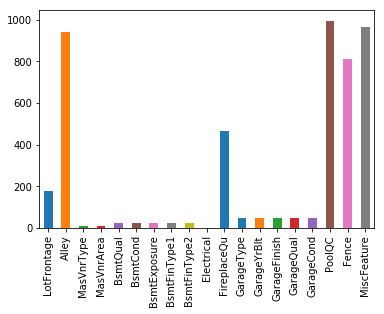

In [6]:
# Visualize Missing Values (both Numerical and Categorical)

trainmissing = train.isnull().sum()
trainmissing = trainmissing[trainmissing>0]

trainmissing
trainmissing.plot.bar()

In [7]:
# Numerical values I will impute NaN with the median (per professors code)
# Determine which columns have NaN

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

# Impute the median value for LotFrontage and GarageYrBlt

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Validation # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Testing # Cols with NaN = 11
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [8]:
# Lot Frontage: Linear feet of street connected to property
out1 = num_train['LotFrontage'].isna().sum()

print('Total Missing Values of LotFrontage in Training =', out1)

Total Missing Values of LotFrontage in Training = 179


To impute the 179 missing values of LotFrontage, we can use the median of a related categorical factor. We looked at BldgType and MSZoning as we assumed both would relate to the linear feet of street connected to the property. Building type median seems to have the best correlation to LotFrontage and we will use it to impute our missing values

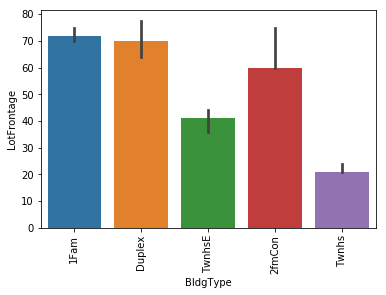

In [9]:
# This shows a bar plot of the median value per group with an error bar showing one standard deviation (to show variability)

sns.barplot(data=train,x='BldgType',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

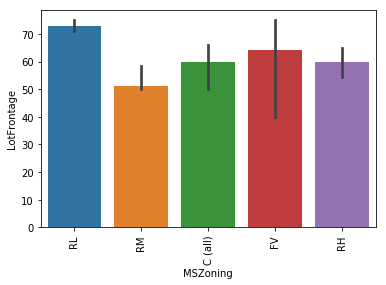

In [10]:
sns.barplot(data=train,x='MSZoning',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

In [11]:
# Assistance in creating this formula
# https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

train['LotFrontage'] = train.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Must also apply this to validation and testing data

valid['LotFrontage'] = valid.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [12]:
# MasVnrArea: Masonry veneer area in square feet

out2 = num_train['MasVnrArea'].isna().sum()

print('Total Missing Values of MasVnrArea in Training =', out2)

Total Missing Values of MasVnrArea in Training = 7


In [13]:
# These 7 missing values also have a missing veneer type

vnr = train[num_train['MasVnrArea'].isna()]
vnr['MasVnrType']

163    NaN
371    NaN
446    NaN
646    NaN
672    NaN
676    NaN
855    NaN
Name: MasVnrType, dtype: object

In [14]:
# We can simply replace all missing values here with 0
# Note, we also must do this for our validation and test data

train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
valid['MasVnrArea'] = valid['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [15]:
# GarageYrBlt: Year garage was built
out3 = num_train['GarageYrBlt'].isna().sum()

print('Total Missing Values of GarageYrBlt in Training =', out3)

garg = train[num_train['GarageYrBlt'].isna()]
garg['GarageType']

Total Missing Values of GarageYrBlt in Training = 48


28     NaN
35     NaN
55     NaN
63     NaN
64     NaN
89     NaN
98     NaN
103    NaN
108    NaN
113    NaN
115    NaN
149    NaN
166    NaN
202    NaN
269    NaN
274    NaN
309    NaN
346    NaN
370    NaN
392    NaN
408    NaN
430    NaN
439    NaN
440    NaN
508    NaN
518    NaN
567    NaN
578    NaN
636    NaN
659    NaN
669    NaN
675    NaN
700    NaN
720    NaN
762    NaN
782    NaN
807    NaN
840    NaN
841    NaN
848    NaN
867    NaN
884    NaN
909    NaN
911    NaN
919    NaN
963    NaN
994    NaN
997    NaN
Name: GarageType, dtype: object

In [16]:
# Similar to before, these values all have a missing garage type meaning there is no garage and we can impute with 0
# Problematically, you cannot simply assign a year to 0. For our purposes we will use the date in which the house was
# built as the value for when the garage would have been built if there was a garage
# Note, we also must do this for our validation and test data

# train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])
# valid['GarageYrBlt'] = valid['GarageYrBlt'].fillna(train['YearBuilt'])
# test['GarageYrBlt'] = test['GarageYrBlt'].fillna(train['YearBuilt'])

# Decided to change and use the median value of GarageYrBlt for these missing values

train['GarageYrBlt'] = train['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))
valid['GarageYrBlt'] = valid['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))
test['GarageYrBlt'] = test['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

In [17]:
# We will do the same for Garage Cars and Garage Area that are missing in our test data set
# We cannot look at this data to determine if this is correct, but we must perform the actions based on our test data

train['GarageCars'] = train['GarageCars'].fillna(0)
valid['GarageCars'] = valid['GarageCars'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)

train['GarageArea'] = train['GarageArea'].fillna(0)
valid['GarageArea'] = valid['GarageArea'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

In [18]:
# Finally, although there are no missing values in the test set for items related to the basement of a home
# our test data does have these issues. We will simply replace these missing values with zero assuming there is no
# basement at this location
# 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'

train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(0)
valid['BsmtFinSF1'] = valid['BsmtFinSF1'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)

train['BsmtFinSF2'] = train['BsmtFinSF2'].fillna(0)
valid['BsmtFinSF2'] = valid['BsmtFinSF2'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)

train['BsmtUnfSF'] = train['BsmtUnfSF'].fillna(0)
valid['BsmtUnfSF'] = valid['BsmtUnfSF'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)

train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(0)
valid['TotalBsmtSF'] = valid['TotalBsmtSF'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)

train['BsmtFullBath'] = train['BsmtFullBath'].fillna(0)
valid['BsmtFullBath'] = valid['BsmtFullBath'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)

train['BsmtHalfBath'] = train['BsmtHalfBath'].fillna(0)
valid['BsmtHalfBath'] = valid['BsmtHalfBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)

In [19]:
# Finally, we double check to make sure we have no more missing numerical values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


In [20]:
# Categorial values we will have to do case by case
# Start by determining which columns have NaN and what they should be replaced by
# For example: If no basement, all basement related will be NaN but they should say No Basement...

# Determine which columns have NaN

trcols = cat_train.columns[cat_train.isna().any()].tolist()
vacols = cat_valid.columns[cat_valid.isna().any()].tolist()
tecols = cat_test.columns[cat_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 16
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Validation # Cols with NaN = 15
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Testing # Cols with NaN = 22
['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [21]:
# Alley: Type of alley access to property where NA equals No Alley

train['Alley'] = train['Alley'].fillna('NoAlley')
valid['Alley'] = valid['Alley'].fillna('NoAlley')
test['Alley'] = test['Alley'].fillna('NoAlley')

In [22]:
# MasVnrType: Masonry veneer type where we will assume NA equals None

train['MasVnrType'] = train['MasVnrType'].fillna('None')
valid['MasVnrType'] = valid['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

Total Missing Values of Utilities in Training = 0


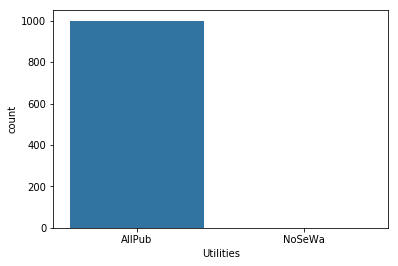

In [23]:
# Utilities: Type of utilities available
# There are no utility missing values in the training data, but we will replace this with all utilities available as
# all properties in the test set have all utilities available

out4 = cat_train['Utilities'].isna().sum()

print('Total Missing Values of Utilities in Training =', out4)

sns.countplot(x='Utilities', data=train)

In [24]:
train['Utilities'] = train['Utilities'].fillna('AllPub')
valid['Utilities'] = valid['Utilities'].fillna('AllPub')
test['Utilities'] = test['Utilities'].fillna('AllPub')

In [25]:
# Similar to our numerical data, we will assume all basement related missing values means there is no basement
# We confirm this below by looking at the numerical values about basements for those entries whose categorical basement values
# contains an NaN

out5 = cat_train['BsmtQual'].isna().sum()

print('Total Missing Values of Basement Quality in Training =', out5)

bsmt = train[cat_train['BsmtQual'].isna()]
bsmt['TotalBsmtSF']

Total Missing Values of Basement Quality in Training = 25


12     0
28     0
65     0
72     0
109    0
128    0
179    0
235    0
249    0
255    0
273    0
385    0
444    0
517    0
535    0
614    0
683    0
717    0
725    0
728    0
758    0
838    0
840    0
847    0
967    0
Name: TotalBsmtSF, dtype: int64

In [26]:
# NoBasement is confirmed and can be replaced in our set
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

train['BsmtQual'] = train['BsmtQual'].fillna('NoBasement')
valid['BsmtQual'] = valid['BsmtQual'].fillna('NoBasement')
test['BsmtQual'] = test['BsmtQual'].fillna('NoBasement')

train['BsmtCond'] = train['BsmtCond'].fillna('NoBasement')
valid['BsmtCond'] = valid['BsmtCond'].fillna('NoBasement')
test['BsmtCond'] = test['BsmtCond'].fillna('NoBasement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('NoBasement')
valid['BsmtExposure'] = valid['BsmtExposure'].fillna('NoBasement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('NoBasement')

train['BsmtFinType1'] = train['BsmtFinType1'].fillna('NoBasement')
valid['BsmtFinType1'] = valid['BsmtFinType1'].fillna('NoBasement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('NoBasement')

train['BsmtFinType2'] = train['BsmtFinType2'].fillna('NoBasement')
valid['BsmtFinType2'] = valid['BsmtFinType2'].fillna('NoBasement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('NoBasement')

Total Missing Values of Electrical in Training = 1


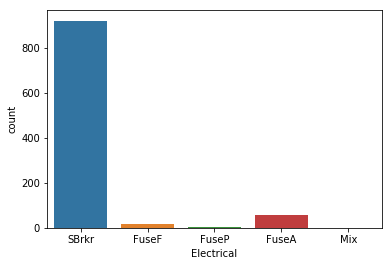

In [27]:
# Electrical: Electrical system

out6 = cat_train['Electrical'].isna().sum()

print('Total Missing Values of Electrical in Training =', out6)

elec = train[cat_train['Electrical'].isna()]
elec

sns.countplot(x='Electrical', data=train)

In [28]:
# There is only one missing electrical value in the test data.
# We will impute this and all others with a standard configuration as this is the most common configuration

train['Electrical'] = train['Electrical'].fillna('SBrkr')
valid['Electrical'] = valid['Electrical'].fillna('SBrkr')
test['Electrical'] = test['Electrical'].fillna('SBrkr')

Total Missing Values of FireplaceQu in Training = 466


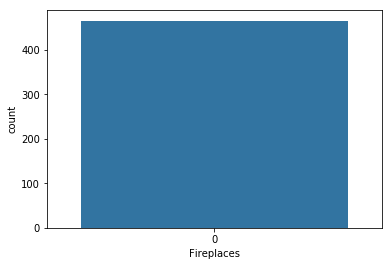

In [29]:
# 'FireplaceQu': Fireplace quality

out7 = cat_train['FireplaceQu'].isna().sum()

print('Total Missing Values of FireplaceQu in Training =', out7)

fire = train[cat_train['FireplaceQu'].isna()]

sns.countplot(x='Fireplaces', data=fire)

In [30]:
# As shown above, all missing fireplace quality values have 0 fireplaces

train['FireplaceQu'] = train['FireplaceQu'].fillna('NoFire')
valid['FireplaceQu'] = valid['FireplaceQu'].fillna('NoFire')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NoFire')

Total Missing Values of PoolQC in Training = 995


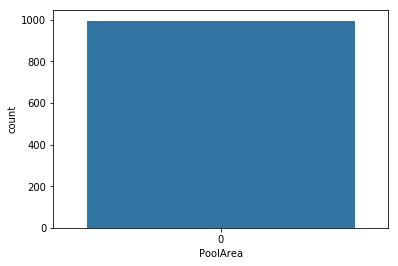

In [31]:
# 'PoolQC'

out8 = cat_train['PoolQC'].isna().sum()

print('Total Missing Values of PoolQC in Training =', out8)

pool = train[cat_train['PoolQC'].isna()]

sns.countplot(x='PoolArea', data=pool)

In [32]:
# As shown above, all missing pool quality values have 0 pools

train['PoolQC'] = train['PoolQC'].fillna('NoPool')
valid['PoolQC'] = valid['PoolQC'].fillna('NoPool')
test['PoolQC'] = test['PoolQC'].fillna('NoPool')

In [33]:
# 'Fence': Fence quality where NA equals no fence

train['Fence'] = train['Fence'].fillna('NoFence')
valid['Fence'] = valid['Fence'].fillna('NoFence')
test['Fence'] = test['Fence'].fillna('NoFence')

In [34]:
# 'MiscFeature': Miscellaneous feature not covered in other categories where NA equals None

train['MiscFeature'] = train['MiscFeature'].fillna('NoMisc')
valid['MiscFeature'] = valid['MiscFeature'].fillna('NoMisc')
test['MiscFeature'] = test['MiscFeature'].fillna('NoMisc')

In [35]:
# Similar to our numerical data, we will assume all garage related missing values means there is no garage
# We confirm this below by looking at the numerical values about garages for those entries whose categorical garage values
# contains an NaN

out9 = cat_train['GarageType'].isna().sum()

print('Total Missing Values of GarageType in Training =', out9)

gara = train[cat_train['GarageType'].isna()]
gara['GarageArea']

Total Missing Values of GarageType in Training = 48


28     0
35     0
55     0
63     0
64     0
89     0
98     0
103    0
108    0
113    0
115    0
149    0
166    0
202    0
269    0
274    0
309    0
346    0
370    0
392    0
408    0
430    0
439    0
440    0
508    0
518    0
567    0
578    0
636    0
659    0
669    0
675    0
700    0
720    0
762    0
782    0
807    0
840    0
841    0
848    0
867    0
884    0
909    0
911    0
919    0
963    0
994    0
997    0
Name: GarageArea, dtype: int64

In [36]:
# NoBasement is confirmed and can be replaced in our set
# 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'

train['GarageType'] = train['GarageType'].fillna('NoGarage')
valid['GarageType'] = valid['GarageType'].fillna('NoGarage')
test['GarageType'] = test['GarageType'].fillna('NoGarage')

train['GarageFinish'] = train['GarageFinish'].fillna('NoGarage')
valid['GarageFinish'] = valid['GarageFinish'].fillna('NoGarage')
test['GarageFinish'] = test['GarageFinish'].fillna('NoGarage')

train['GarageQual'] = train['GarageQual'].fillna('NoGarage')
valid['GarageQual'] = valid['GarageQual'].fillna('NoGarage')
test['GarageQual'] = test['GarageQual'].fillna('NoGarage')

train['GarageCond'] = train['GarageCond'].fillna('NoGarage')
valid['GarageCond'] = valid['GarageCond'].fillna('NoGarage')
test['GarageCond'] = test['GarageCond'].fillna('NoGarage')

In [37]:
# These features were not missing in the Training data but were missing in the Test Data
# 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType'

# 'MSZoning', Utilities', 'Functional', 'KitchenQual' will replace with most frequent value

train['MSZoning'] = train['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['MSZoning'] = valid['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['MSZoning'] = test['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Utilities'] = train['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Utilities'] = valid['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Utilities'] = test['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Functional'] = train['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Functional'] = valid['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Functional'] = test['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['KitchenQual'] = train['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['KitchenQual'] = valid['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['KitchenQual'] = test['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))

# 'Exterior1st', 'Exterior2nd', 'SaleType' will replace with Other

train['Exterior1st'] = train['Exterior1st'].fillna('Other')
valid['Exterior1st'] = valid['Exterior1st'].fillna('Other')
test['Exterior1st'] = test['Exterior1st'].fillna('Other')

train['Exterior2nd'] = train['Exterior2nd'].fillna('Other')
valid['Exterior2nd'] = valid['Exterior2nd'].fillna('Other')
test['Exterior2nd'] = test['Exterior2nd'].fillna('Other')

train['SaleType'] = train['SaleType'].fillna('Other')
valid['SaleType'] = valid['SaleType'].fillna('Other')
test['SaleType'] = test['SaleType'].fillna('Other')

In [38]:
# Confirm I have removed all NaNs

trcols = train.columns[train.isna().any()].tolist()
vacols = valid.columns[valid.isna().any()].tolist()
tecols = test.columns[test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


### Remove Outliers

In [39]:
num_train = train.select_dtypes(exclude=['object'])
trcols = num_train.columns.tolist()
trcols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

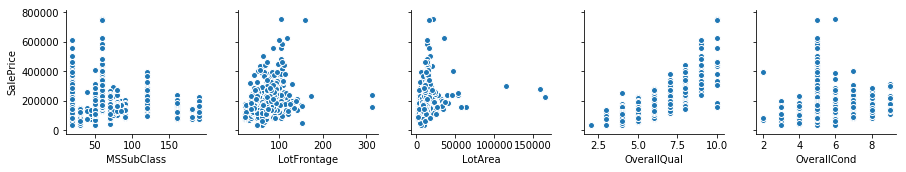

In [40]:
# Start by graphing all of the numerical values
# Remove outliers based on housing price

sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'])

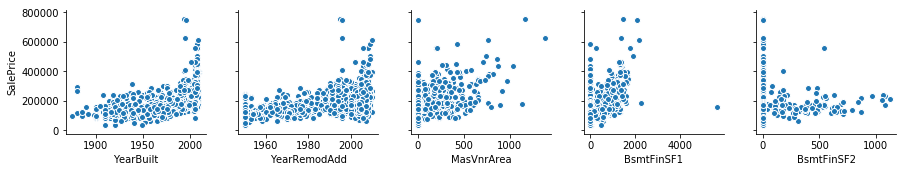

In [41]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'])

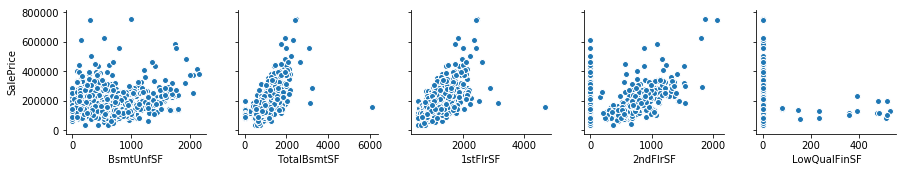

In [42]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

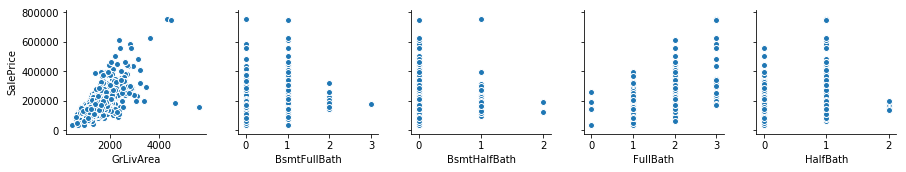

In [43]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'])

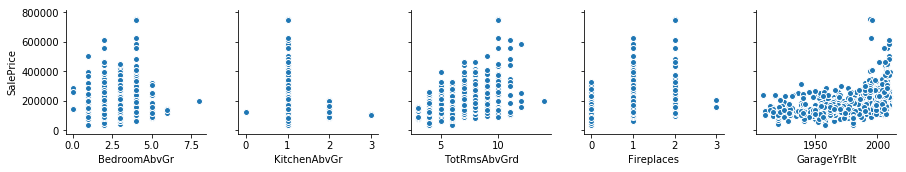

In [44]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt'])

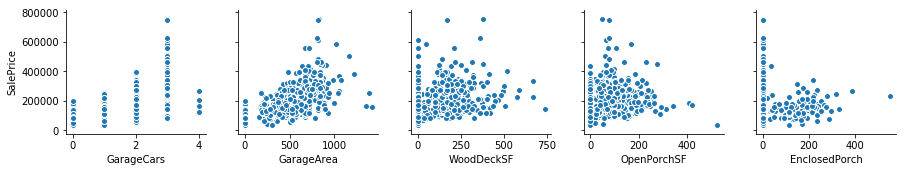

In [45]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'])

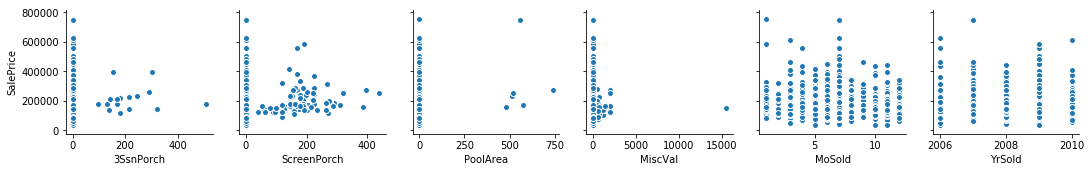

In [46]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'])

In [47]:
# Outliers are as follows (only removed from training data)
# LotFrontage > 300, LotArea > 100000, BsmtFinSF1 > 4000, TotalBsmtSF > 4000, 1stFlrSF > 4000
# GrLivArea > 4600, 3SsnPorch > 400, MiscVal > 10000

train = train.drop(train[(train['LotFrontage']>300) |
                         (train['LotArea']>100000) |
                         (train['BsmtFinSF1']>4000) |
                         (train['TotalBsmtSF']>4000) |
                         (train['1stFlrSF']>4000) |
                         (train['GrLivArea']>4600) |
                         (train['3SsnPorch']>400) |
                         (train['MiscVal']>10000)].index)

valid = valid.drop(valid[(valid['LotFrontage']>300) |
                         (valid['LotArea']>100000) |
                         (valid['BsmtFinSF1']>4000) |
                         (valid['TotalBsmtSF']>4000) |
                         (valid['1stFlrSF']>4000) |
                         (valid['GrLivArea']>4600) |
                         (valid['3SsnPorch']>400) |
                         (valid['MiscVal']>10000)].index)

## Issues with Training and Validation Set
After running model an initial time, a number of the test columns contained values not seen in the Test / Validation set. In order to fix this, we create a value 'Other' and impute those values with few entries.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

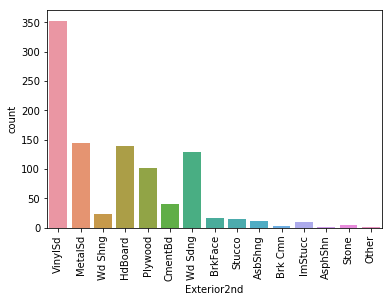

In [48]:
# Test/Validation dataset column 'Exterior2nd' has levels not trained on: [CBlock]

sns.countplot(x='Exterior2nd', data=train)
plt.xticks(rotation=90)

In [49]:
# Add value CBlock to Other in all three test sets

train['Exterior2nd'] = train['Exterior2nd'].replace('CBlock', 'Other')
valid['Exterior2nd'] = valid['Exterior2nd'].replace('CBlock', 'Other')
test['Exterior2nd'] = test['Exterior2nd'].replace('CBlock', 'Other')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

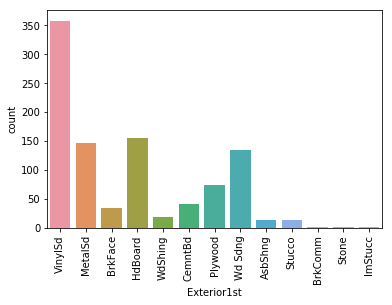

In [50]:
# Test/Validation dataset column 'Exterior1st' has levels not trained on: [AsphShn, CBlock]
# Test/Validation dataset column 'Exterior1st' has levels not trained on: [AsphShn, CBlock, Other]

sns.countplot(x='Exterior1st', data=train)
plt.xticks(rotation=90)

In [51]:
train['Exterior1st'] = train['Exterior1st'].replace(['AsphShn', 'CBlock','ImStucc'], 'Other')
valid['Exterior1st'] = valid['Exterior1st'].replace(['AsphShn', 'CBlock','ImStucc'], 'Other')
test['Exterior1st'] = test['Exterior1st'].replace(['AsphShn', 'CBlock','ImStucc'], 'Other')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

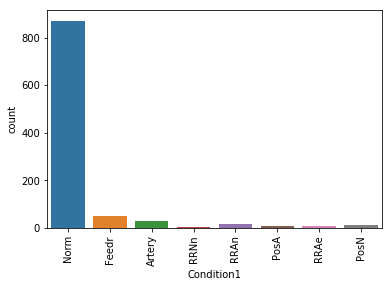

In [52]:
# Test/Validation dataset column 'Condition1' has levels not trained on: [RRNe]

sns.countplot(x='Condition1', data=train)
plt.xticks(rotation=90)

In [53]:
train['Condition1'] = train['Condition1'].replace(['RRNn','RRNe'], 'Other')
valid['Condition1'] = valid['Condition1'].replace(['RRNn','RRNe'], 'Other')
test['Condition1'] = test['Condition1'].replace(['RRNn','RRNe'], 'Other')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

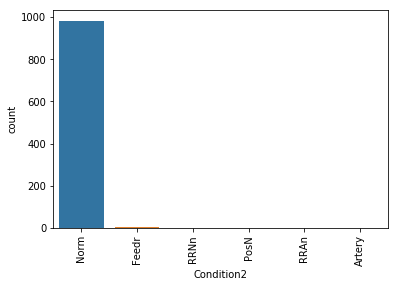

In [54]:
# Test/Validation dataset column 'Condition2' has levels not trained on: [PosA, RRAe]
# Test/Validation dataset column 'Condition2' has levels not trained on: [PosA]

sns.countplot(x='Condition2', data=train)
plt.xticks(rotation=90)

In [55]:
train['Condition2'] = train['Condition2'].replace(['PosA','RRAe','RRNn'], 'Other')
valid['Condition2'] = valid['Condition2'].replace(['PosA','RRAe','RRNn'], 'Other')
test['Condition2'] = test['Condition2'].replace(['PosA','RRAe','RRNn'], 'Other')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

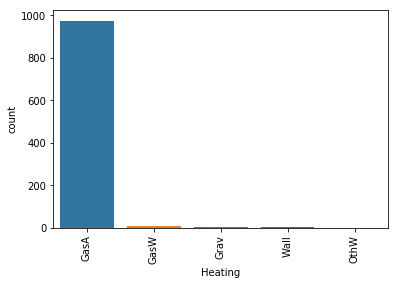

In [56]:
# Test/Validation dataset column 'Heating' has levels not trained on: [Floor]

sns.countplot(x='Heating', data=train)
plt.xticks(rotation=90)

In [57]:
train['Heating'] = train['Heating'].replace(['Floor'], 'OthW')
valid['Heating'] = valid['Heating'].replace(['Floor'], 'OthW')
test['Heating'] = test['Heating'].replace(['Floor'], 'OthW')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

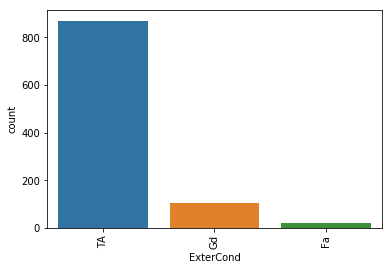

In [58]:
# Test/Validation dataset column 'ExterCond' has levels not trained on: [Ex, Po]

sns.countplot(x='ExterCond', data=train)
plt.xticks(rotation=90)

In [59]:
train['ExterCond'] = train['ExterCond'].replace(['Ex','Po','Fa'], 'Other')
valid['ExterCond'] = valid['ExterCond'].replace(['Ex','Po','Fa'], 'Other')
test['ExterCond'] = test['ExterCond'].replace(['Ex','Po','Fa'], 'Other')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

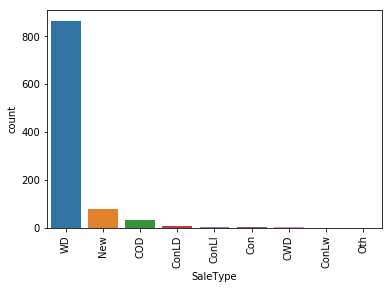

In [60]:
# Test/Validation dataset column 'SaleType' has levels not trained on: [Other]

sns.countplot(x='SaleType', data=train)
plt.xticks(rotation=90)

In [61]:
train['SaleType'] = train['SaleType'].replace('Other', 'Oth')
valid['SaleType'] = valid['SaleType'].replace('Other', 'Oth')
test['SaleType'] = test['SaleType'].replace('Other', 'Oth')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

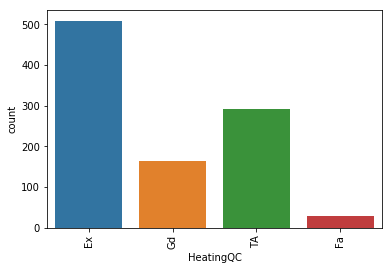

In [62]:
# Test/Validation dataset column 'HeatingQC' has levels not trained on: [Po]

sns.countplot(x='HeatingQC', data=train)
plt.xticks(rotation=90)

In [63]:
train['HeatingQC'] = train['HeatingQC'].replace(['Po','Fa'], 'Other')
valid['HeatingQC'] = valid['HeatingQC'].replace(['Po','Fa'], 'Other')
test['HeatingQC'] = test['HeatingQC'].replace(['Po','Fa'], 'Other')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

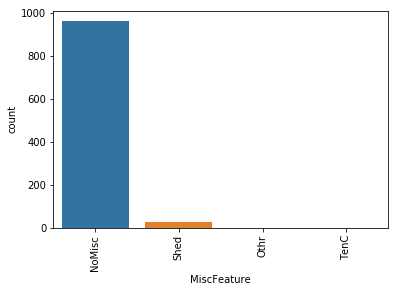

In [64]:
# Test/Validation dataset column 'MiscFeature' has levels not trained on: [Gar2]

sns.countplot(x='MiscFeature', data=train)
plt.xticks(rotation=90)

In [65]:
train['MiscFeature'] = train['MiscFeature'].replace('Gar2', 'Othr')
valid['MiscFeature'] = valid['MiscFeature'].replace('Gar2', 'Othr')
test['MiscFeature'] = test['MiscFeature'].replace('Gar2', 'Othr')

### Normalize home prices (log transform per notes)

C:\Users\Davee\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


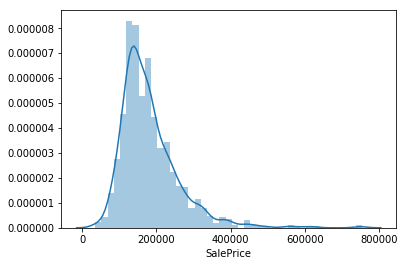

In [66]:
sns.distplot(train['SalePrice'])

In [67]:
# Apply log transform
train["SalePrice"] = train["SalePrice"].apply(np.log)
valid["SalePrice"] = valid["SalePrice"].apply(np.log)

C:\Users\Davee\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


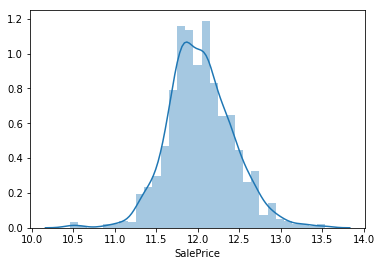

In [68]:
# Normalized data
sns.distplot(train['SalePrice'])

### One-Hot Encoding of Categorical Variables

In [69]:
# Need to re-initialize my categorical dataframes with updated / imputed information

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [70]:
# Taken directly from professor's code

# one-hot encode training frame
train_cats_df = cat_train
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = cat_valid
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = cat_test
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

(993, 232)
(457, 232)
True
(993, 228)
(457, 228)
True
(993, 228)
(457, 228)
(1459, 228)
True


In [71]:
# convert back to h2o to combine
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = h2o.H2OFrame(train)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = h2o.H2OFrame(valid)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = h2o.H2OFrame(test)
test = test.cbind(test_one_hot)

In [72]:
# Convert back to Pandas

trainside = train.as_data_frame()
validside = valid.as_data_frame()
testside = test.as_data_frame()

# Create only numeric

num_train_fin = trainside.select_dtypes(exclude=['object'])
num_valid_fin = validside.select_dtypes(exclude=['object'])
num_test_fin = testside.select_dtypes(exclude=['object'])

# Convert back to h2o

num_train_fin = h2o.H2OFrame(num_train_fin)
num_valid_fin = h2o.H2OFrame(num_valid_fin)
num_test_fin = h2o.H2OFrame(num_test_fin)

# Now we have two sets in H2O, all columns and numeric only

In [73]:
# Decided to simply use all columns in training
# Using the heat map in this code, we could have worked on variable selection

# corrmat = train.corr()
# f, ax = plt.subplots(figsize=(50, 15))
# sns.heatmap(corrmat, vmax=0.8, square=True,center=0)

In [74]:
# Encoding Categorical Variables: http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf

# This is an option to try later on

In [75]:
# Can also try the combined features from professor's code

## Perform Analysis

### Define GLM Model with Grid Search (per professor's code)

In [76]:
def  glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

### Also define function to generate submission file (per professor's code)
### and ranked predictions plot

In [77]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/GLMsubmission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

In [78]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [79]:
h2o.show_progress()

In [80]:
# Used to create a list of columns for our H2O models

colselect = train.as_data_frame()
colselect = colselect.drop('SalePrice', 1)
glm_cols = colselect.columns.tolist()

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                    model_ids  \
0    [0.99]  Grid_GLM_py_8_sid_a4fa_model_python_1529618379651_1_model_3   
1     [0.5]  Grid_GLM_py_8_sid_a4fa_model_python_1529618379651_1_model_2   
2    [0.25]  Grid_GLM_py_8_sid_a4fa_model_python_1529618379651_1_model_1   
3    [0.01]  Grid_GLM_py_8_sid_a4fa_model_python_1529618379651_1_model_0   

   residual_deviance  
0  5.434983282085863  
1  5.436104981171313  
2  5.448934385491922  
3  5.952937462433834  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_8_sid_a4fa_model_python_1529618379651_1_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.010215764159561947
RMSE: 0.10107306347173785
MAE: 0.07202110060519969
RMSLE: 0.007870908744551874
R^2: 0.9342879185020695
Mean Residual Deviance: 0.010215764159561947
Null degrees of freedom: 992
Resi

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-06-21 18:00:35,0.000 sec,1,.32E0,1,0.1554625,0.1684591
,2018-06-21 18:00:35,0.013 sec,2,.31E0,2,0.1463011,0.1579085
,2018-06-21 18:00:35,0.022 sec,3,.3E0,2,0.1379501,0.1482940
,2018-06-21 18:00:35,0.030 sec,4,.28E0,2,0.1303377,0.1395330
,2018-06-21 18:00:35,0.059 sec,5,.27E0,2,0.1233989,0.1315500
---,---,---,---,---,---,---,---
,2018-06-21 18:00:36,1.220 sec,88,.57E-2,84,0.0100821,0.0118943
,2018-06-21 18:00:36,1.229 sec,89,.54E-2,85,0.0099599,0.0119033
,2018-06-21 18:00:36,1.242 sec,90,.52E-2,85,0.0098466,0.0119219
,2018-06-21 18:00:36,1.258 sec,91,.49E-2,86,0.0097427,0.0119411



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0551
12.2061,12.3262
11.6784,11.7143
11.7906,11.776
11.9117,11.962
11.9767,11.9211
11.8451,11.7464
11.1346,11.2496
11.914,11.8118
11.8845,11.9063



glm prediction progress: |████████████████████████████████████████████████| 100%


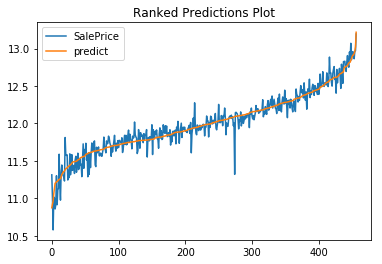

In [81]:
glm_0 = glm_grid(glm_cols, 'SalePrice', train, valid)
gen_submission(glm_0)

In [82]:
# Initial score of 0.12759
# After fixing warnings/errors, score of 0.12759 (did not change)
# After fixing garage error, score of 0.12751 (improvement)
# Changed garage error to median instead of YearBuilt, maintained score of 0.12751 (did not change) + RMSE 0.1116
# Altered code to drop SalePrice from X variables, score of 0.12850

### To Improve Accuracy, try additional models
##### (All code taken from Professor's notebook)

In [83]:
# Different submission generator

import re
import time

def gen_submission2(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/RFsubmission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

## Random Forest

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1529618379651_2


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.02794652031797852
RMSE: 0.16717212781435342
MAE: 0.11510043248693566
RMSLE: 0.01294739375650381
Mean Residual Deviance: 0.02794652031797852

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.029619039864574665
RMSE: 0.17210182992802447
MAE: 0.11896847479525662
RMSLE: 0.013334526575198033
Mean Residual Deviance: 0.029619039864574665

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.02737611024535953
RMSE: 0.1654572761934619
MAE: 0.1138909267382869
RMSLE: 0.012810838781440403
Mean Residual Deviance: 0.02737611024535953
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.1137986,0.0014720,0.1117376,0.1166497,0.1130084
mean_residual_deviance,0.0273099,0.0010638,0.0264881,0.0294204,0.0260211
mse,0.0273099,0.0010638,0.0264881,0.0294204,0.0260211
r2,0.8239453,0.0049507,0.8258367,0.8145826,0.8314165
residual_deviance,0.0273099,0.0010638,0.0264881,0.0294204,0.0260211
rmse,0.1651953,0.0031914,0.1627516,0.1715237,0.1613107
rmsle,0.0127859,0.0002874,0.0124604,0.0133590,0.0125384


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-21 18:01:07,27.439 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-21 18:01:07,27.482 sec,1.0,0.3124131,0.2186631,0.0976020,0.3084523,0.2265508,0.0951428
,2018-06-21 18:01:07,27.531 sec,2.0,0.2789017,0.1972450,0.0777861,0.2386963,0.1741154,0.0569759
,2018-06-21 18:01:07,27.581 sec,3.0,0.2544721,0.1816209,0.0647560,0.2248117,0.1626399,0.0505403
,2018-06-21 18:01:07,27.638 sec,4.0,0.2592010,0.1821827,0.0671851,0.2196005,0.1574775,0.0482244
---,---,---,---,---,---,---,---,---,---
,2018-06-21 18:01:21,41.392 sec,179.0,0.1673640,0.1150722,0.0280107,0.1721509,0.1190489,0.0296359
,2018-06-21 18:01:21,41.515 sec,180.0,0.1672585,0.1150886,0.0279754,0.1720783,0.1189601,0.0296109
,2018-06-21 18:01:21,41.619 sec,181.0,0.1672944,0.1151462,0.0279874,0.1721776,0.1190334,0.0296451
,2018-06-21 18:01:21,41.727 sec,182.0,0.1672398,0.1150366,0.0279692,0.1722357,0.1191073,0.0296651



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ExterQual,1344.4860840,1.0,0.0612831
Neighborhood,1159.5078125,0.8624171,0.0528516
KitchenQual,1146.6669922,0.8528664,0.0522663
YearBuilt,1106.1260986,0.8227129,0.0504184
GarageArea,975.6389771,0.7256594,0.0444706
---,---,---,---
Condition2_Other,0.0133748,0.0000099,0.0000006
Utilities_AllPub,0.0,0.0,0.0
Exterior2nd_AsphShn,0.0,0.0,0.0
SaleType_ConLw,0.0,0.0,0.0



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9922
12.2061,12.1678
11.6784,11.8078
11.7906,11.7334
11.9117,11.9517
11.9767,11.9787
11.8451,11.7903
11.1346,11.4713
11.914,11.8856
11.8845,12.0413



drf prediction progress: |████████████████████████████████████████████████| 100%


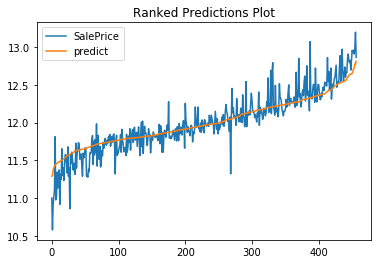

In [84]:
# initialize rf model (not using a defined function as before)
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=glm_cols,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, rf_preds1_val)
rf_preds1_test = rf_model1.predict(test)
gen_submission2(rf_preds1_test)

## Extremely Random Forest

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1529618379651_3


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.0304350085216713
RMSE: 0.17445632267611083
MAE: 0.12125959622971433
RMSLE: 0.013517078509492388
Mean Residual Deviance: 0.0304350085216713

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.03243340103185283
RMSE: 0.18009275674455327
MAE: 0.1253911356772953
RMSLE: 0.01394126783132151
Mean Residual Deviance: 0.03243340103185283

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.029432620546475368
RMSE: 0.1715593790688092
MAE: 0.11905413458394908
RMSLE: 0.0132700984644275
Mean Residual Deviance: 0.029432620546475368
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.1189759,0.0017829,0.1154526,0.1212122,0.1202630
mean_residual_deviance,0.0293875,0.0007091,0.0285798,0.0308010,0.0287816
mse,0.0293875,0.0007091,0.0285798,0.0308010,0.0287816
r2,0.8104990,0.0023462,0.8120832,0.8058817,0.813532
residual_deviance,0.0293875,0.0007091,0.0285798,0.0308010,0.0287816
rmse,0.1714031,0.0020567,0.1690557,0.1755020,0.1696515
rmsle,0.0132537,0.0002106,0.0129326,0.0136502,0.0131784


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-21 18:01:42,17.704 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-21 18:01:42,17.736 sec,1.0,0.3273061,0.2259996,0.1071293,0.3169249,0.2269988,0.1004414
,2018-06-21 18:01:42,17.771 sec,2.0,0.2886062,0.2012277,0.0832935,0.2408029,0.1747914,0.0579860
,2018-06-21 18:01:42,17.806 sec,3.0,0.2660499,0.1895574,0.0707825,0.2289591,0.1614957,0.0524223
,2018-06-21 18:01:42,17.836 sec,4.0,0.2667882,0.1922211,0.0711759,0.2166564,0.1559163,0.0469400
---,---,---,---,---,---,---,---,---,---
,2018-06-21 18:01:53,29.357 sec,163.0,0.1747277,0.1212397,0.0305298,0.1792312,0.1249839,0.0321238
,2018-06-21 18:01:53,29.451 sec,164.0,0.1746917,0.1212006,0.0305172,0.1796249,0.1252189,0.0322651
,2018-06-21 18:01:53,29.549 sec,165.0,0.1745794,0.1212508,0.0304780,0.1800763,0.1254416,0.0324275
,2018-06-21 18:01:53,29.645 sec,166.0,0.1746751,0.1213931,0.0305114,0.1801426,0.1254553,0.0324513



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Neighborhood,1362.9108887,1.0,0.0614528
ExterQual,1362.7954102,0.9999153,0.0614476
YearBuilt,1142.0419922,0.8379433,0.0514940
GarageArea,1002.2345581,0.7353632,0.0451902
OverallQual,854.0929565,0.6266682,0.0385105
---,---,---,---
Utilities_AllPub,0.0000034,0.0000000,0.0000000
RoofStyle_Shed,0.0,0.0,0.0
Exterior2nd_AsphShn,0.0,0.0,0.0
MiscFeature_Othr,0.0,0.0,0.0



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9837
12.2061,12.1645
11.6784,11.8197
11.7906,11.7406
11.9117,11.9376
11.9767,11.9685
11.8451,11.7914
11.1346,11.4921
11.914,11.8592
11.8845,12.024



drf prediction progress: |████████████████████████████████████████████████| 100%


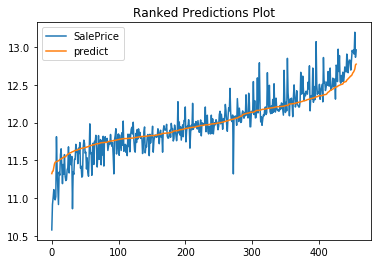

In [85]:
# initialize extra trees model
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=glm_cols,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, ert_preds1_val)
ert_preds1_test = ert_model1.predict(test)
gen_submission2(ert_preds1_test)

## H2O Gradient Boosted Machine

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1529618379651_4


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0039698124629336225
RMSE: 0.0630064477885686
MAE: 0.04131523239888694
RMSLE: 0.0049475502324747055
Mean Residual Deviance: 0.0039698124629336225

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.01270129141531272
RMSE: 0.11270000627911571
MAE: 0.07858933869928172
RMSLE: 0.008761841187236146
Mean Residual Deviance: 0.01270129141531272

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.015696138671406352
RMSE: 0.12528423153536264
MAE: 0.08715101627429216
RMSLE: 0.009755335694698043
Mean Residual Deviance: 0.015696138671406352
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0869699,0.0029357,0.0849200,0.0927596,0.0832301
mean_residual_deviance,0.0156031,0.0014616,0.0139186,0.0185144,0.0143763
mse,0.0156031,0.0014616,0.0139186,0.0185144,0.0143763
r2,0.8995531,0.0081321,0.9084831,0.8833159,0.9068601
residual_deviance,0.0156031,0.0014616,0.0139186,0.0185144,0.0143763
rmse,0.1246486,0.0057364,0.1179771,0.1360676,0.1199012
rmsle,0.0096987,0.0004919,0.0090484,0.0106632,0.0093847


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-21 18:06:36,4 min 39.937 sec,0.0,0.3942873,0.3051797,0.1554625,0.4104377,0.3211808,0.1684591
,2018-06-21 18:06:36,4 min 39.968 sec,1.0,0.3929094,0.3039471,0.1543778,0.4089498,0.3198085,0.1672400
,2018-06-21 18:06:36,4 min 40.000 sec,2.0,0.3917399,0.3029358,0.1534602,0.4078327,0.3188805,0.1663275
,2018-06-21 18:06:36,4 min 40.018 sec,3.0,0.3902612,0.3017147,0.1523038,0.4061933,0.3175217,0.1649930
,2018-06-21 18:06:36,4 min 40.033 sec,4.0,0.3888082,0.3004311,0.1511718,0.4046933,0.3161732,0.1637766
---,---,---,---,---,---,---,---,---,---
,2018-06-21 18:08:16,6 min 20.118 sec,7099.0,0.0664337,0.0435812,0.0044134,0.1119568,0.0776197,0.0125343
,2018-06-21 18:08:20,6 min 24.125 sec,7364.0,0.0654140,0.0429958,0.0042790,0.1120950,0.0780202,0.0125653
,2018-06-21 18:08:24,6 min 28.133 sec,7634.0,0.0645332,0.0423149,0.0041645,0.1122551,0.0784243,0.0126012
,2018-06-21 18:08:28,6 min 32.135 sec,7940.0,0.0635366,0.0416979,0.0040369,0.1125698,0.0785431,0.0126720



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,4923.1606445,1.0,0.4469972
Neighborhood,2413.4860840,0.4902310,0.2191319
GrLivArea,903.0767212,0.1834343,0.0819946
KitchenQual,453.3946838,0.0920942,0.0411659
FireplaceQu,195.1079102,0.0396306,0.0177148
---,---,---,---
SaleType_ConLI,0.0,0.0,0.0
SaleType_ConLw,0.0,0.0,0.0
SaleType_Oth,0.0,0.0,0.0
SaleCondition_Alloca,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.1956
12.2061,12.2901
11.6784,11.745
11.7906,11.824
11.9117,11.9319
11.9767,11.9009
11.8451,11.7625
11.1346,11.1759
11.914,11.8088
11.8845,11.9076



gbm prediction progress: |████████████████████████████████████████████████| 100%


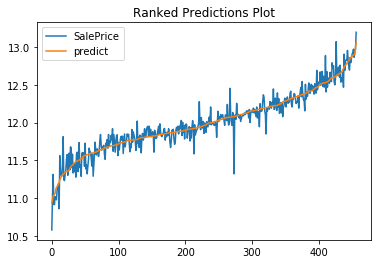

In [86]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=glm_cols,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val)
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission2(h2o_gbm_preds1_test)

## H2O XGBoost

In [87]:
# H2O XGBOOST IS NOT SUPPORTED ON WINDOWS CURRENTLY

# initialize XGB GBM
# h2o_xgb_model = H2OXGBoostEstimator(
#     ntrees = 10000,
#     learn_rate = 0.005,
#     sample_rate = 0.1, 
#     col_sample_rate = 0.8,
#     max_depth = 5,
#     nfolds = 3,
#     keep_cross_validation_predictions=True,
#     stopping_rounds = 10,
#     seed = 12345)

# # execute training 
# h2o_xgb_model.train(x=glm_cols,
#                     y='SalePrice',
#                     training_frame=train,
#                     validation_frame=valid)

# # print model information/create submission
# print(h2o_xgb_model)
# h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
# ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
# h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
# gen_submission2(h2o_xgb_preds1_test)

## H2O Stacked Model of all previous models

stackedensemble Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_model_python_1529618379651_5
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.0033277874159356306
RMSE: 0.057686977871402055
MAE: 0.0403200210530789
RMSLE: 0.004503376169256075
R^2: 0.9785942750372649
Mean Residual Deviance: 0.0033277874159356306
Null degrees of freedom: 992
Residual degrees of freedom: 989
Null deviance: 154.37425781079114
Residual deviance: 3.304492904024081
AIC: -2837.497575093726

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.012712766326572042
RMSE: 0.11275090388361435
MAE: 0.07988444214055701
RMSLE: 0.00876190758843001
R^2: 0.9242040814189961
Mean Residual Deviance: 0.012712766326572042
Null degrees of freedom: 456
Residual degrees of freedom: 453
Null deviance: 76.98582338792609
Residual de

SalePrice,predict
11.8494,12.1518
12.2061,12.2761
11.6784,11.7451
11.7906,11.7863
11.9117,11.9321
11.9767,11.9154
11.8451,11.7535
11.1346,11.2014
11.914,11.8158
11.8845,11.938



stackedensemble prediction progress: |████████████████████████████████████| 100%


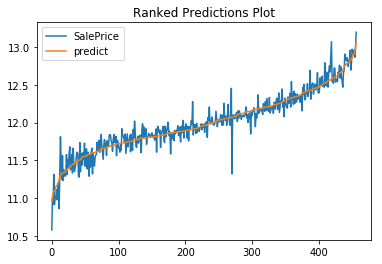

In [88]:
stack = H2OStackedEnsembleEstimator(training_frame=train, 
                                    validation_frame=valid, 
                                    base_models=[rf_model1, ert_model1, 
                                                 h2o_gbm_model])

stack.train(x=glm_cols,
            y='SalePrice',
            training_frame=train,
            validation_frame=valid)

# print model information/create submission
print(stack)
stack_preds1_val = stack.predict(valid)
ranked_preds_plot('SalePrice', valid, stack_preds1_val) 
stack_preds1_test = stack.predict(test)
gen_submission2(stack_preds1_test)

## XGBoost Model

In [89]:
# Different submission generator

import re
import time

def gen_submission3(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/submission_XGBoost.csv'
    h2o.download_csv(sub, sub_fname)

[0]	train-rmse:0.380429	eval-rmse:0.396433
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.368248	eval-rmse:0.384038
[2]	train-rmse:0.356451	eval-rmse:0.371982
[3]	train-rmse:0.345604	eval-rmse:0.362656
[4]	train-rmse:0.334213	eval-rmse:0.35149
[5]	train-rmse:0.326092	eval-rmse:0.343439
[6]	train-rmse:0.31777	eval-rmse:0.336112
[7]	train-rmse:0.30836	eval-rmse:0.326717
[8]	train-rmse:0.299284	eval-rmse:0.31847
[9]	train-rmse:0.290561	eval-rmse:0.308865
[10]	train-rmse:0.283037	eval-rmse:0.301968
[11]	train-rmse:0.275097	eval-rmse:0.293688
[12]	train-rmse:0.268855	eval-rmse:0.287352
[13]	train-rmse:0.263138	eval-rmse:0.282175
[14]	train-rmse:0.255587	eval-rmse:0.274634
[15]	train-rmse:0.250165	eval-rmse:0.269508
[16]	train-rmse:0.243465	eval-rmse:0.262806
[17]	train-rmse:0.237786	eval-rmse:0.256686
[18]	train-rmse:0.232495	eval-rmse:0.250796
[19]	train-rmse:0.227586	eval-rmse:

[183]	train-rmse:0.084459	eval-rmse:0.117781
[184]	train-rmse:0.084152	eval-rmse:0.117756
[185]	train-rmse:0.084051	eval-rmse:0.117575
[186]	train-rmse:0.084019	eval-rmse:0.117289
[187]	train-rmse:0.083817	eval-rmse:0.116976
[188]	train-rmse:0.083771	eval-rmse:0.117014
[189]	train-rmse:0.08357	eval-rmse:0.11687
[190]	train-rmse:0.083497	eval-rmse:0.116908
[191]	train-rmse:0.083481	eval-rmse:0.116869
[192]	train-rmse:0.083318	eval-rmse:0.11664
[193]	train-rmse:0.083238	eval-rmse:0.116432
[194]	train-rmse:0.083039	eval-rmse:0.116499
[195]	train-rmse:0.083007	eval-rmse:0.116352
[196]	train-rmse:0.082977	eval-rmse:0.116477
[197]	train-rmse:0.082604	eval-rmse:0.116448
[198]	train-rmse:0.082456	eval-rmse:0.116071
[199]	train-rmse:0.08225	eval-rmse:0.11613
[200]	train-rmse:0.08215	eval-rmse:0.116198
[201]	train-rmse:0.081933	eval-rmse:0.116242
[202]	train-rmse:0.081818	eval-rmse:0.116371
[203]	train-rmse:0.08167	eval-rmse:0.116493
[204]	train-rmse:0.081482	eval-rmse:0.116497
[205]	train-rmse:

SalePrice,predict
11.8494,12.0045
12.2061,12.2268
11.6784,11.814
11.7906,11.8356
11.9117,11.8796
11.9767,11.9014
11.8451,11.7788
11.1346,11.1157
11.914,11.8188
11.8845,11.992



Parse progress: |█████████████████████████████████████████████████████████| 100%


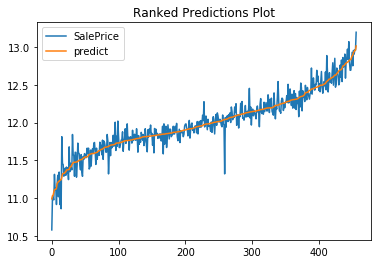

In [92]:
ave_y = train['SalePrice'].mean()[0]

colselect2 = num_train_fin.as_data_frame()
colselect2 = colselect2.drop('SalePrice', 1)
glm_cols2 = colselect2.columns.tolist()

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain1 = xgb.DMatrix(num_train_fin.as_data_frame()[glm_cols2],
                      num_train_fin.as_data_frame()['SalePrice'])
dvalid1 = xgb.DMatrix(num_valid_fin.as_data_frame()[glm_cols2],
                      num_valid_fin.as_data_frame()['SalePrice'])
dtest = xgb.DMatrix(num_test_fin.as_data_frame()[glm_cols2])

# tuning parameters
params1 = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.05,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 6,
    'reg_alpha' : 0.09,
    'reg_lambda' : 0.6,
    'base_score': ave_y,
    'silent': 0,
    'seed': 42,
}

# watchlist is used for early stopping
watchlist = [(dtrain1, 'train'), (dvalid1, 'eval')]

# train model
xgb_model1 = xgb.train(params1, 
                       dtrain1, 
                       10000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)

# create assessment stats and submission file
xgb_preds1_val = h2o.H2OFrame(xgb_model1.predict(dvalid1).tolist())
ranked_preds_plot('SalePrice', valid, xgb_preds1_val) 
xgb_preds1_test = h2o.H2OFrame(xgb_model1.predict(dtest).tolist())
gen_submission3(xgb_preds1_test)

## Blended Scikit Learn Lasso and XGBoost Model
1. https://www.kaggle.com/davidprakash/xgboost

### First we build our XGBoost Model

In [93]:
# First I need to take my numerical only h2o frames and convert them back to pandas data frames
train_df_pre = num_train_fin.as_data_frame()
train_df = train_df_pre.drop('SalePrice', 1)
test_df = num_test_fin.as_data_frame()

# I also need to create a prediction (y) value dataframe
label_df = train_df_pre["SalePrice"]

# Then I can build my XGBoost model (using the parameters from Prakash notebook)
xgbmod2 = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

# Fit this model to the training data
xgbmod2.fit(train_df, label_df)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.05,
       max_delta_step=0, max_depth=6, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1,
       seed=42, silent=1, subsample=0.2)

In [94]:
# RMSE error function for training

from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [95]:
# Run prediction on training set and get our RMSE
y_pred1 = xgbmod2.predict(train_df)
y_test1 = label_df
rmse_xgb=rmse(y_test1, y_pred1)
print("XGBoost score on training set: ", rmse_xgb)

XGBoost score on training set:  0.04363994447889395


In [96]:
# Run prediction on the Kaggle test set.
y_pred_xgb = xgbmod2.predict(test_df)

### Then we build our Scikit Learn Lasso model

In [97]:
from sklearn.linear_model import Lasso

# Use alpha and lasso model from Prakash notebook
best_alpha = 0.00099

scikl = Lasso(alpha=best_alpha, max_iter=50000)

# Fit the model to our training data
scikl.fit(train_df, label_df)

Lasso(alpha=0.00099, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [98]:
# Run prediction on training set and get our RMSE
y_pred2 = scikl.predict(train_df)
y_test2 = label_df
rmse_lasso=rmse(y_test2, y_pred2)
print("Lasso score on training set: ", rmse_lasso)

Lasso score on training set:  0.10362776033174974


In [99]:
# Run prediction on the Kaggle test set.
y_pred_lasso = scikl.predict(test_df)

In [121]:
y_pred_lasso

array([11.68793638, 11.80228401, 12.10977297, ..., 12.05486194,
       11.65058616, 12.34108199])

### Then we blend and create our results

In [100]:
# Blend the two models

# Add them together and weight the lasso model more heavily then average
y_pred =  (y_pred_xgb + y_pred_lasso*1.1) / 2.1
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput.csv', header=True, index_label='Id')

## Final Attempt will be to expand on our Blending but with our best models

In [132]:
# Our Top two scores (ignoring the blended model)

# GLM with RMSE 0.10905

sub = test['Id'].cbind(glm_0.predict(test))
sub.columns = ['Id', 'SalePrice']
glmblend = sub.as_data_frame()
y_pred_glm = glmblend['SalePrice'].values

glm prediction progress: |████████████████████████████████████████████████| 100%


In [133]:
# XGBoost with RMSE 0.11415

sub2 = test['Id'].cbind(xgb_preds1_test)
sub2.columns = ['Id', 'SalePrice']
xgbblend = sub2.as_data_frame()
y_pred_xgb1 = xgbblend['SalePrice'].values

In [137]:
# Then we blend the two models

y_pred =  (y_pred_glm + y_pred_xgb1) / 2
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput2.csv', header=True, index_label='Id')

In [ ]:
# This improved our pre-blending scores to 0.12629

In [138]:
# I will now blend these two models with our Scikit Learn and XGB Blended Model

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso) / 4
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput3.csv', header=True, index_label='Id')


In [ ]:
# This continued to improve our pre-blending scores to 0.12330

In [140]:
# I will now try to weight our Lasso model more heavily

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso*1.1) / 4.1
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput4.csv', header=True, index_label='Id')

In [ ]:
# This is our best score yet: 0.12316

In [141]:
# I will now try to weight our Lasso model even more heavily

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso*1.25) / 4.25
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput5.csv', header=True, index_label='Id')

In [ ]:
# Continued Improvement: 0.12298

In [142]:
# I will now try to weight our Lasso model even more heavily

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso*2) / 5
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput6.csv', header=True, index_label='Id')

In [ ]:
# Continued Improvement: 0.12235

In [143]:
# I will now try to weight our Lasso model even more heavily

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso*4) / 7
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput7.csv', header=True, index_label='Id')

In [ ]:
# Continued Improvement: 0.12181

In [144]:
# I will now try to weight our Lasso model even more heavily

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso*8) / 11
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput8.csv', header=True, index_label='Id')

In [ ]:
# Very Large Increase Caused issues and dropped the score: 0.12183

In [145]:
# I will now try to weight our Lasso model even more heavily

y_pred =  (y_pred_glm + y_pred_xgb1 + y_pred_xgb + y_pred_lasso*6) / 9
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput9.csv', header=True, index_label='Id')

In [ ]:
# Last attempt is to simply drop the other two model but use a heavy weight on our Sci Kit Learn Model

In [146]:
# Blend the two models

# Add them together and weight the lasso model more heavily then average
y_pred =  (y_pred_xgb + y_pred_lasso*6) / 7
y_pred = np.exp(y_pred)

# Output to file for submission
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('blendedoutput10.csv', header=True, index_label='Id')

# Final Model Comparison

In [ ]:
## GLM: Score 0.12850 + Validation RMSE 0.10905
## Random Forest: Score 0.18307 + Validation RMSE 0.17210
## Extremely Random Forest: Score 0.19277 + Validation RMSE 0.18009
## H2O Gradient Boosted Machine: Score 0.13062 + Validation RMSE 0.12528
## H2O XGBoost: NOT SUPPORTED ON WINDOWS MACHINES
## H2O Stacked (All Models): Score 0.12952 + Validation RMSE 0.11275 (might be overfitting -> train RMSE 0.0548)
## XGBoost: Score 0.13258 + Validation RMSE 0.11415
## Blended Model: Score 0.12322
## Blended Model 2: Score 0.12629 (Better than GLM)
## Blended Model 3: Score 0.12330
## Blended Model 4: Score 0.12316
## Blended Model 5: Score 0.12298
## Blended Model 6: Score 0.12235 
## Blended Model 7: Score 0.12181 
## Blended Model 8: Score 0.12183 (dropped from previous high)
## Blended Model 9: Score 0.12176 (BEST SCORE)
## Blended Model 10: Score 0.12221 (not an improvement)

### For future improvement: blending of more models, changing of weighting in blending, changing of parameters for certain models, and changes / improvements to data pre-processing